# Image time frame normalization approach

In [29]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.models import Sequential
from keras.layers import MaxPooling2D, Conv2D, Reshape, Dense, Flatten, Dropout
from sys import getsizeof
from sklearn.metrics import mean_squared_error
from math import sqrt

## Data extraction methods

In [30]:
# Where you put the image file,
# It can be either relative or absolute path
image_folder = "MultiModHandGestUAV"

#Input shpae, 120 rows, 320 columns. Each cell has 1 dimension of colour
INPUT_SHAPE = (120,320,1)

# All subjects available
SUBJECT_NUMBERS = tuple(i for i in range(0,2))

#No. of subjects to train at once due to memory constraint
#Doesn't affect test data sets
SUBJECTS_PER_ITER = 5

#Exclude the "ele" label for now.
GOOD_LABELS = {"cam_b", "cam_f", "cam_l", "cam_r", "down", "left", "right", "up", "zoom_in", "zoom_out"}

#Show a few images each time image file are read
IMAGES_TO_SHOW = 5

def _break_down_path(image_path):
    """
    Break down the path image_path into 5 components and return them:
    1. subject: the subject number (in str) 
    2. is_sequence = "sequence" if not static image
    3. label: Which action the sequence is 
    4. typ: either "train" or "test"
    5. sequence_no, "seq_x"
    **Please note if the folder is for static images, the components break-down 
      will not be correct. You can check if sequence_no starts with "seq_" for confirmation 
    """
    #Image_path looks like "MultiModHandGestUAV\00\sequences\cam_f\train\seq_0"
    image_path, sequence_no = os.path.split(image_path)
    image_path, typ = os.path.split(image_path)
    image_path, label = os.path.split(image_path)
    image_path, is_sequence = os.path.split(image_path)
    _, subject = os.path.split(image_path)
    return subject, is_sequence, label, typ, sequence_no


def get_seq_path(subject_nos=None, gesture_names=None, target_type = "train"):
    """
    Given an array of numbers in subject_nos, or names in gesture_names
    returns a list where each row is tuple(image_fullpath, label, seq_uid, which_frame, total_frame_in_sequence)
    seq_uid = subject_number + sequence_no + label, used to uniquely identify a sequence.
    """
    result = []
    
    #Path would look like "MultiModHandGestUAV\00\sequences\cam_f\train\seq_0"
    for folder, sub_folders, files in os.walk(image_folder):
        if len(sub_folders) == 0 and len(files) > 0:  #Reached a folder with no subfolder
            subject, is_sequence, label, typ, sequence_no = _break_down_path(folder)
            
            if sequence_no.startswith("seq_") and \
                (int(subject) in subject_nos if subject_nos is not None else True) and \
                (label in gesture_names if gesture_names is not None else True) and \
                typ == target_type:
                num_files = len(files)
                seq_uid = "%s|%s|%s" % (subject, sequence_no, label)
                for i in range(num_files):
                    result.append(tuple([os.path.join(folder, files[i]), label, seq_uid, i ,num_files]))
    return result


def read_image(fullpath):
    """
    Read a single image specified fullpath
    """
    img = Image.open(fullpath).convert('L')
    img = img.resize((INPUT_SHAPE[1], INPUT_SHAPE[0]))
    result = np.array(img).reshape(INPUT_SHAPE) / 255.0
    return result


def process_image_rows(image_file_data):
    """
    Read the tuple list returned by get_seq_path and convert them into x, y, l np_arry
    where x is the np array of all images, l is the label array, and y is the normalized timestamp
    """
    #each row is tuple(image_fullpath, label, which_frame, total_frame_in_sequence)
    x = []
    y = []
    l = []
    
    for row in image_file_data:
        x.append(read_image(row[0]))
        y.append(row[3]/row[4])
        l.append(row[1])
    
    x = np.array(x, dtype="float32")
    y = np.array(y, dtype="float32")
    l = np.array(l)
    
    return x, y, l

def get_image_data(subject_nos=None, gesture_names=None, target_type = "train"):
    """
    Given the subject number, gestures names, and training or test,
    return a np array respresentation of that data.
    Return x, y, l = labels, s = unique sequence ID
    """
    image_data = get_seq_path(subject_nos, gesture_names, target_type)
    x, y, l = process_image_rows(image_data)
    s = np.array(image_data)[:,2]
    return x, y, l, s

## Create 11 models, one for each gesture
All models can be accessed in models, which is dict. Keys are label names.

In [31]:
#Print the mode summary only once
first_print = True

models = {}
for a_label in GOOD_LABELS:
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(4,4), strides=(1,1) , activation='relu',input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D (pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(64, kernel_size=(5,5), strides=(1,1) , activation='relu'))
    model.add(MaxPooling2D (pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(64, kernel_size=(5,5), strides=(1,1) , activation='relu'))
    model.add(MaxPooling2D (pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(64, kernel_size=(5,5), strides=(1,1) , activation='relu'))
    model.add(MaxPooling2D (pool_size=(2,2),strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(10,kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    if first_print:
        print(model.summary())
        first_print = False
    if first_print:
        print(model.summary())
        first_print = False
    model.compile(loss='mean_squared_error', optimizer=tf.train.AdamOptimizer())
    models[a_label] = model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 117, 317, 64)      1088      
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 58, 158, 64)       0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 54, 154, 64)       102464    
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 27, 77, 64)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 23, 73, 64)        102464    
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 11, 36, 64)        0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 7, 32, 64)         102464    
__________

## Get Train Data and fit model iteratively
Due to memory constraint, we shall do it SUBJECTS_PER_ITER subjects at a time.
Try to make this work even if you have only 16GB RAM.

Be care with memory management. Release whatever you don't need.

Getting training data for subject(s) 0,1
X Train shape: (10714, 120, 320, 1)
Show a few training images:


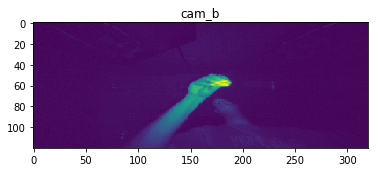

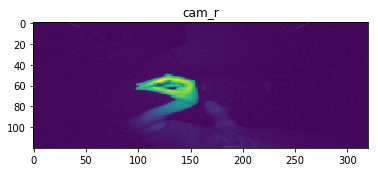

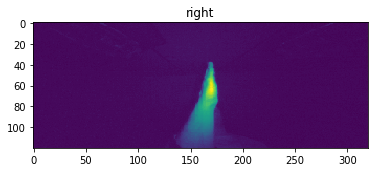

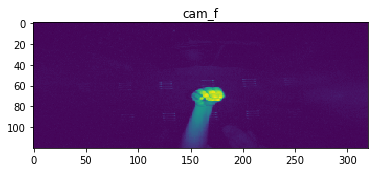

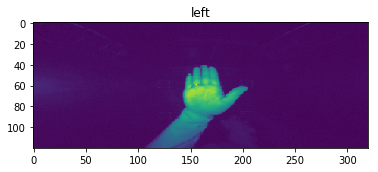

1591 entries with label "left" are found.
Epoch 1/20
1591/1591 [==============================] - 6s 4ms/step - loss: 0.0296
Epoch 2/20
1591/1591 [==============================] - 5s 3ms/step - loss: 0.0252
Epoch 3/20
1591/1591 [==============================] - 5s 3ms/step - loss: 0.0190
Epoch 4/20
1591/1591 [==============================] - 5s 3ms/step - loss: 0.0160
Epoch 5/20
1591/1591 [==============================] - 5s 3ms/step - loss: 0.0161
Epoch 6/20
1591/1591 [==============================] - 5s 3ms/step - loss: 0.0147
Epoch 7/20
1591/1591 [==============================] - 5s 3ms/step - loss: 0.0126
Epoch 8/20
1591/1591 [==============================] - 5s 3ms/step - loss: 0.0109
Epoch 9/20
1591/1591 [==============================] - 5s 3ms/step - loss: 0.0096
Epoch 10/20
1591/1591 [==============================] - 5s 3ms/step - loss: 0.0091
Epoch 11/20
1591/1591 [==============================] - 5s 3ms/step - loss: 0.0076A: 0s - l
Epoch 12/20
1591/1591 [===========

1237/1237 [==============================] - 4s 3ms/step - loss: 0.0205
Epoch 5/20
1237/1237 [==============================] - 4s 3ms/step - loss: 0.0213
Epoch 6/20
1237/1237 [==============================] - 4s 3ms/step - loss: 0.0181
Epoch 7/20
1237/1237 [==============================] - 4s 3ms/step - loss: 0.0169
Epoch 8/20
1237/1237 [==============================] - 4s 3ms/step - loss: 0.0145
Epoch 9/20
1237/1237 [==============================] - 4s 3ms/step - loss: 0.0150A: 0s - loss: 0
Epoch 10/20
1237/1237 [==============================] - 4s 3ms/step - loss: 0.0146
Epoch 11/20
1237/1237 [==============================] - 4s 3ms/step - loss: 0.0123
Epoch 12/20
1237/1237 [==============================] - 4s 3ms/step - loss: 0.0127
Epoch 13/20
1237/1237 [==============================] - 4s 3ms/step - loss: 0.0117
Epoch 14/20
1237/1237 [==============================] - 4s 3ms/step - loss: 0.0098
Epoch 15/20
1237/1237 [==============================] - 4s 3ms/step - loss: 0

In [32]:
for i in range(min(SUBJECT_NUMBERS),max(SUBJECT_NUMBERS) // SUBJECTS_PER_ITER + 1):
    subject_nos = [j for j in range(i * SUBJECTS_PER_ITER, (i + 1) * SUBJECTS_PER_ITER)\
                   if j in SUBJECT_NUMBERS]
    
    print("Getting training data for subject(s) %s" % ",".join([str(j) for j in subject_nos]))
    x_train, y_train, l_train, _ = get_image_data(subject_nos, GOOD_LABELS, "train")
    print("X Train shape:", x_train.shape)
    
    print("Show a few training images:")
    for i in range(0, IMAGES_TO_SHOW):
        plt.imshow(x_train[int(x_train.shape[0] / IMAGES_TO_SHOW * i)].reshape((INPUT_SHAPE[0], INPUT_SHAPE[1])))
        plt.title(l_train[int(x_train.shape[0] / IMAGES_TO_SHOW * i)])
        plt.show()
    
    for a_label in GOOD_LABELS:
        row_nos = np.where(l_train == a_label)
        print("%d entries with label \"%s\" are found." %(row_nos[0].shape[0], a_label,))
        models[a_label].fit(x_train[row_nos],
                            y_train[row_nos], batch_size = 10, epochs=20)
        y_pred = models[a_label].predict(x_train[row_nos])
        print("sqrt(MSE) is ", sqrt(mean_squared_error(y_pred.ravel(), y_train[row_nos])))
        print("---------------------------------------------")
    
    #Relase the memory, as we no longer need the training data
    del x_train, y_train,l_train
    print("***********************************************************\n")

## Get Test Data

In [33]:
image_data = get_seq_path(subject_nos=[0,1,], target_type="test")
test_image_data = np.array(image_data)

x_test, y_test, l_test = process_image_rows(image_data)

print("X Test shape:", x_test.shape)

X Test shape: (2935, 120, 320, 1)


## Read Testing data
Currently for test data, all images are read at once.

Print a few test Images:


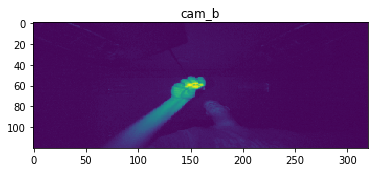

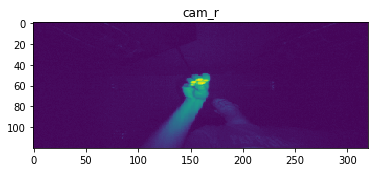

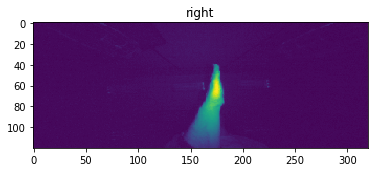

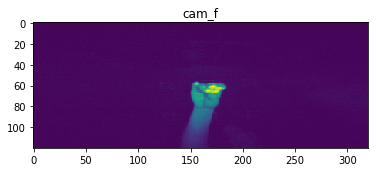

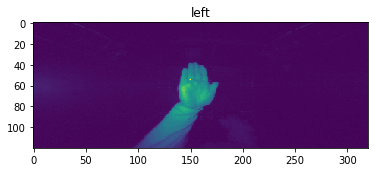

In [34]:
x_test, y_test, l_test, s_test = get_image_data(SUBJECT_NUMBERS, GOOD_LABELS, "test")
print("Print a few test Images:")
for i in range(0, IMAGES_TO_SHOW):
    plt.imshow(x_test[int(x_test.shape[0] / IMAGES_TO_SHOW * i)].reshape((INPUT_SHAPE[0], INPUT_SHAPE[1])))
    plt.title(l_test[int(x_test.shape[0] / IMAGES_TO_SHOW * i)])
    plt.show()


## Get test prediction

In [35]:
all_seqs = tuple(np.unique(s_test))
right = 0
wrong = 0
aaa = {}
bbb = {}
for a_seq in all_seqs:
    matching_indices = np.where(s_test == a_seq)
    
    mse = {}
    lab = tuple(np.unique(l_test[matching_indices]))
    
    for a_label in GOOD_LABELS:
        y_pred = models[a_label].predict(x_test[matching_indices])
        mse[a_label] = mean_squared_error(y_pred.ravel(), y_test[matching_indices])
    
    if min(mse, key=mse.get) == lab[0]:
        right += 1
    else:
        wrong += 1
        
        if lab[0] in aaa:
            aaa[lab[0]] += 1
        else:
            aaa[lab[0]] = 1
            
        if min(mse, key=mse.get) in bbb:
            bbb[min(mse, key=mse.get)] += 1
        else:
            bbb[min(mse, key=mse.get)] = 1

In [36]:
print(right, wrong, right/(right+wrong))

print(aaa, bbb)

145 17 0.8950617283950617
{'right': 5, 'up': 4, 'down': 2, 'cam_b': 3, 'zoom_out': 1, 'cam_f': 1, 'zoom_in': 1} {'zoom_in': 4, 'left': 2, 'zoom_out': 4, 'up': 3, 'down': 1, 'cam_b': 1, 'right': 1, 'cam_r': 1}


In [37]:
del x_test, y_test, l_test, s_test